In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.decomposition import PCA
from pprint import pprint

<h3> Import Data

In [2]:
patients = pd.read_csv('./Robo/Data/patient.csv',index_col='PatientGuid').sort_index()
diagnosis = pd.read_csv('./Robo/Data/diagnosis.csv',index_col='PatientGuid').sort_index()
physicians = pd.read_csv('./Robo/Data/physician_specialty.csv',index_col='PatientGuid').sort_index()
transcripts = pd.read_csv('./Robo/Data/transcript.csv',index_col='PatientGuid').sort_index()
medications = pd.read_csv('./Robo/Data/medication.csv',index_col='PatientGuid').sort_index()
medications.columns = map(lambda x:'med_'+x,medications.columns)
data = pd.concat([diagnosis,physicians,transcripts,medications,patients], axis=1)
data.fillna(0,inplace=True)

#create artificial IDs, to keep track of training and validation sets later

data['ID'] = range(data.shape[0])


c:\users\rupadhyay\python 3.6\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


Separate different independent variables by data types. Set numerical and categorical apart

In [3]:
target = 'DMIndicator'
categorical = ['Gender','State']
categorical += [x for x in data.columns if 'Icd' in x]
categorical += [x for x in data.columns if 'PhySp' in x]
numerical = data[[x for x in data.columns if (x not in categorical)]].columns.tolist()
categorical += ['ID']



### Exploratory Data Analysis - 
Create functions to quickly view visualizations 

In [4]:
def hist_numerical(df,col,nbins=10,target='DMIndicator',yscale='linear',normalize=False):
    x = df[col]
    hy1,hx1 = np.histogram(df[col][df[target] == 1],bins=nbins,normed=normalize)
    hy2,hx2 = np.histogram(df[col][df[target] == 0],bins=hx1,normed=normalize)
    w = 0.4*(hx1[1]-hx1[0])
    plt.figure(figsize=(5,3))
    plt.bar(hx1[:-1],hy1,width=w,color='blue',edgecolor='none')
    plt.bar(hx2[:-1]+w,hy2,width=w,color='green',edgecolor='none')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.yscale(yscale)
    plt.legend([1,0],title=target)
    print (col, stats.ttest_ind(df[col][df[target] == 1],df[col][df[target] == 0]))
    
def bar_categorical(df,col,target='DMIndicator',yscale='linear',normalize=False,title_on=False):
    
    x = pd.concat([df[df[target] == 1][col].value_counts(normalize = normalize),
                   df[df[target] == 0][col].value_counts(normalize = normalize)],axis=1)
    x.columns = [1,0]
    w = 0.4*(x.index[1] - x.index[0])
    plt.bar(x.index,x[1],color='b',width=w)
    plt.bar(x.index+w,x[0],color='g',width=w)
    if col != target: plt.xticks(x.index+w,x.index)
    else:plt.xticks([0.6,1.2],x.index)
    plt.yscale(yscale)
    plt.xlabel(col.split('_')[-1])
    if not normalize:plt.ylabel('Count')
    else:plt.ylabel('Frequency')
    plt.legend([1,0],title=target.split('_')[-1])
    if title_on: plt.title('Distribution of '+col.split('_')[-1])
    x.columns = [target.split('_')[-1]+'_1',target.split('_')[-1]+'_0']
    x.index = map(lambda x:col.split('_')[-1]+'_'+str(x),x.index)
    return x


def box_numerical(df,col,target='DMIndicator',ylim=[0,25]):
    
    plt.figure(figsize=(5,3))
    plt.boxplot([df[col][df[target] == 0],df[col][df[target] == 1]])
    plt.xticks([1,2],[0,1])
    plt.ylim(ylim)
    plt.ylabel(col)
    print (col,stats.ttest_ind(df[col][df[target] == 1],df[col][df[target] == 0]))
    

#### Use above functions to visualize data and run statistical tests

AcuteCount Ttest_indResult(statistic=0.2668335437764089, pvalue=0.7896028580400105)


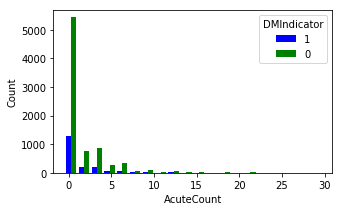

In [5]:
n = 3
hist_numerical(data,numerical[n],nbins=20,yscale='linear',normalize=False)
#hist_numerical(data,'Age',nbins=20,yscale='linear',normalize=True)
#hist_numerical(data,'BMI_Max',nbins=20,yscale='linear',normalize=True)
#box_numerical(data,'BMI_Max',ylim=[15,45])
#plt.show()
#print (numerical[n], n,'/',len(numerical))

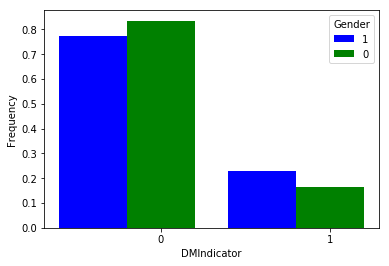

In [6]:
bar_categorical(data,col='DMIndicator',target='Gender',yscale='linear',title_on=False, normalize=True)
plt.show()

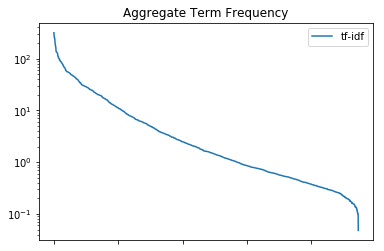

In [7]:
tfidf_agg = medications.sum().sort_values(ascending=False)
d_tfidf_agg = -(tfidf_agg - tfidf_agg.shift())#.sort_values()
tfidf_agg.plot()
#d_tfidf_agg.plot()
plt.yscale('log')
plt.title("Aggregate Term Frequency")
plt.xticks(rotation=90)
plt.legend(['tf-idf','derivative'])
plt.show()

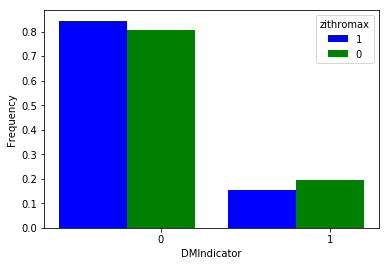

,zithromax_1,zithromax_0
DMIndicator_0,0.844291,0.805198
DMIndicator_1,0.155709,0.194802


In [9]:
highest_lowest_tfidf = tfidf_agg[(tfidf_agg<0.2) | (tfidf_agg>50)].index.tolist()
col = highest_lowest_tfidf[9]
df = 1*(data[[col]+['DMIndicator']]>0)
xx = bar_categorical(df,col='DMIndicator',target=col,normalize=True)
plt.show()
xx

In [8]:
#after having a look at each variable, consider noting down those found not import according to the stat tests
non_important = ['DiagnosisFreq','AcuteCount','Height_Max','Temperature_Max','Weight_Min','BMI_Min',
                 'RespiratoryRate_Min','Temperature_Std','Height_Mean','Height_Change','RespiratoryRate_Change',
                 'Temperature_Change']

## Model 
##### First prepare different set of labels as we optimize and cross validate proposed model. Then, we split the data into training and validation sets.

In [12]:
#import scikit learn libraries
from sklearn import cross_validation, metrics #model optimization and valuation tool
from sklearn.grid_search import GridSearchCV #performing grid search
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


In [13]:
#create functions to tune parameters

def modelfit(alg,dtrain,predictors,target,scoring_method,performCV=True,printFeatureImportance=True,cv_folds=5):
    #Train the algorithm on data, This functions train the model given as 'alg' by performing cross-validation
    alg.fit(dtrain[predictors],dtrain[target])
    
    #predict on training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    if scoring_method == 'roc_auc':
        dtrain_predprob = alg.predict_proba(dtrain[predictors]) [:,1]
    
    #Perform cross validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=cv_folds,scoring=scoring_method)
        #print model report
        print ("\n Model Report: ")
        if (scoring_method == 'roc_auc'):
            print("Accuracy : ",metrics.accuracy_score(dtrain[target].values,dtrain_predictions))
            print("AUC score (Train):", metrics.roc_auc_score(dtrain[target],dtrain_predprob))  
        
        if (scoring_method == 'mean_squared_error'):
            print("Accuracy : ",metrics.mean_squared_error(dtrain[target].values,dtrain_predictions))
    
    if performCV:
        print("CV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature importance
    if printFeatureImportance:
        if dir(alg)[0] == '_Booster':
            feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
            
        else:
            feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=False)
            
        feat_imp.plot(kind='bar',title='Feature Importances')
        plt.ylabel('Feature Importance score')
        plt.show()
        
    return alg

def optimize_num_trees(alg,param_test,scoring_method,train,predictors,target):
    #This functions is used to tune paremeters of a predictive algorithm
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test, scoring = scoring_method, n_jobs=2,iid=False, cv=5)
    gsearch.fit(train[predictors],train[target])
    return gsearch
    
    

In [26]:
#Create different set of labels 
labels1 = []
labels2 = numerical[:]
labels2.pop(labels2.index('DMIndicator'))
labels3 = list(filter(lambda x: not x.startswith('med'),list(set(numerical).difference(set(non_important)))))
labels3.pop(labels3.index('DMIndicator'))
labels4 = categorical[:]
labels5 = ['ID','Icd9_390-459', 'State', 'Icd9_240-279', 'PhySp_Internal_Medicine', 'PhySp_Family_Practice', 'PhySp_General_Practice', 'Icd9_780-799', 'PhySp_Unknown', 'Icd9_710-739', 'Icd9_E-V', 'Gender', 'PhySp_Geriatric_Medicine', 'Icd9_290-319', 'PhySp_Podiatry', 'PhySp_Cardiovascular_Disease', 'PhySp_Pulmonary_Disease', 'Icd9_580-629', 'PhySp_Endocrinology__Diabetes__Metabolism', 'PhySp_Adolescent_Medicine', 'PhySp_Nephrology', 'Icd9_280-289', 'Icd9_460-519', 'Icd9_320-359', 'Icd9_680-709', 'Icd9_520-579']
labels6 = list(filter(lambda x: x.startswith('med'),data.columns))+['ID']
#labels6 = list(set(labels6).difference(set(highest_lowest_tfidf)))

#split data into training and validation sets
_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[labels6],data[target],test_size=1/4.,random_state=123)
_train_ids = _Xtrain.ID.tolist()
_valid_ids = _Xvalid.ID.tolist()

labels2.pop(labels2.index('ID'))
labels3.pop(labels3.index('ID'))
labels4.pop(labels4.index('ID'))
labels5.pop(labels5.index('ID'))
labels6.pop(labels6.index('ID'))


'ID'

#### Optimizing parameters to tune the Model

In [41]:
gbm1 = GradientBoostingClassifier(
    learning_rate = 0.1,
    min_samples_split = 2,
    max_depth = 2,
    max_features='auto',
    subsample=0.8,
    random_state=10
)
train = _Xtrain.copy()

train['DMIndicator'] = _Ytrain
param_test = {'n_estimators': np.arange(10,151,20)} #labels5->range(250,501,20), labels6->range(10,151,20)
predictors = labels6
#train[predictors] = standardize(train[predictors])

# optimize number of trees
gs_cls = optimize_num_trees(gbm1,param_test,'roc_auc',train,predictors,target)
print ("Best Parameters:\n\t",gs_cls.best_params_)
print ("Best Score:\n\t",gs_cls.best_score_)
print ("Grid Scores:")
pprint(gs_cls.grid_scores_)


# cross validate the best model with optimized number of estimators
alg = modelfit(gs_cls.best_estimator_,train,predictors,target,'roc_auc',printFeatureImportance=False)

# testing on a different set
ypred = gs_cls.best_estimator_.predict(_Xvalid[predictors])
print ("ROC AUC:", metrics.roc_auc_score(ypred,_Yvalid))

#Best parameter for labels6 is n_estimators = 150




Best Parameters:
	 {'n_estimators': 150}
Best Score:
	 0.7064692456611624
Grid Scores:
[mean: 0.65214, std: 0.01388, params: {'n_estimators': 10},
 mean: 0.67488, std: 0.01585, params: {'n_estimators': 30},
 mean: 0.68537, std: 0.01473, params: {'n_estimators': 50},
 mean: 0.69282, std: 0.02066, params: {'n_estimators': 70},
 mean: 0.69854, std: 0.02393, params: {'n_estimators': 90},
 mean: 0.70091, std: 0.02090, params: {'n_estimators': 110},
 mean: 0.70247, std: 0.02099, params: {'n_estimators': 130},
 mean: 0.70647, std: 0.02032, params: {'n_estimators': 150}]

 Model Report: 
Accuracy :  0.8312558638252245
AUC score (Train): 0.7821724006317572
CV Score - Mean : 0.7064692 | Std : 0.02031813 | Min : 0.6869453 | Max : 0.7324134
ROC AUC: 0.689884503560918


#### Use optimized parameters to make final predictions

In [43]:
# prep training and validation
train = data[data.ID.isin(_train_ids)]
valid = data[data.ID.isin(_valid_ids)]

# set optimized parameters
gbm_num = GradientBoostingClassifier(n_estimators = 90,learning_rate = 0.1,
                                     min_samples_split=2,max_depth=2,max_features='auto',
                                     subsample=0.8,random_state = 10)
gbm_cat = GradientBoostingClassifier(n_estimators = 350,learning_rate = 0.1,
                                     min_samples_split=2,max_depth=2,max_features='auto',
                                     subsample=0.8,random_state = 10)
gbm_med = GradientBoostingClassifier(n_estimators= 150, learning_rate=0.1,
                                     min_samples_split=2, max_depth=2, max_features='auto',
                                     subsample=0.8,random_state = 10)

#train the model
print ("Training models")
print ("---------------")
print ("-- Numerical variables --")
alg_num = modelfit(gbm_num,train,labels3,target,'roc_auc',printFeatureImportance=False)
print ("-- Categorical variables --")
alg_cat = modelfit(gbm_cat,train,labels5,target,'roc_auc',printFeatureImportance=False)
print ("-- Medication Names --")
alg_med = modelfit(gbm_med,train,labels6,target,'roc_auc',printFeatureImportance=False)

Training models
---------------
-- Numerical variables --

 Model Report: 
Accuracy :  0.8234821069561721
AUC score (Train): 0.8135981936323368
CV Score - Mean : 0.7728041 | Std : 0.01484019 | Min : 0.7492446 | Max : 0.7921707
-- Categorical variables --

 Model Report: 
Accuracy :  0.8339364696421391
AUC score (Train): 0.827498807830612
CV Score - Mean : 0.7743218 | Std : 0.009253442 | Min : 0.7620274 | Max : 0.7905083
-- Medication Names --

 Model Report: 
Accuracy :  0.8324621364428361
AUC score (Train): 0.7852540776351796
CV Score - Mean : 0.7003864 | Std : 0.01776058 | Min : 0.6782328 | Max : 0.7221127


In [46]:
#Make Predictions
ypred_num = alg_num.predict(valid[labels3])
ypred_cat = alg_cat.predict(valid[labels5])
ypred_med = alg_med.predict(valid[labels6])
ypredprob_num = alg_num.predict_proba(valid[labels3])[:,1]
ypredprob_cat = alg_cat.predict_proba(valid[labels5])[:,1]
ypredprob_med = alg_med.predict_proba(valid[labels6])[:,1]

#create an ensemble of models based of categorical and numerical variables
ypred_combo = ((0.5*ypredprob_num + 0.0*ypredprob_cat +0.5*ypredprob_med)>0.5)*1

print ("====== Model validation ======")
print ("Summary results")
print ("ROC AUC - numerical variables model:", round(metrics.roc_auc_score(ypred_num,valid[target]),3))
print ("ROC AUC - categorical variables model:", round(metrics.roc_auc_score(ypred_cat,valid[target]),3))
print ("ROC AUC - medication names model:", round(metrics.roc_auc_score(ypred_med,valid[target]),3))
print ("ROC AUC - ensemble model:", round(metrics.roc_auc_score(ypred_combo,valid[target]),3))



====== Model validation ======
Summary results
ROC AUC - numerical variables model: 0.691
ROC AUC - categorical variables model: 0.69
ROC AUC - medication names model: 0.736
ROC AUC - ensemble model: 0.806


### Optimize weights for the final ensemble model

Use a Modified Gradient Descent algorithm to find the best weights to allocate to each of the three models

In [66]:
def loss(w,yps):
    yp_combo = ((w[0]*yps[0]+w[1]*yps[1]+w[2]*yps[2])>0.5)*1
    return 1-metrics.roc_auc_score(yp_combo,valid[target])


def dloss(w,yps,learning_rate = 0.0001):
    dw = [metrics.roc_auc_score(yps[0]>0.5,valid[target]),
          metrics.roc_auc_score(yps[0]>0.5,valid[target]),
          metrics.roc_auc_score(yps[0]>0.5,valid[target])]
    w = [w[i] - (learning_rate*dw[i]) for i in range(len(w))]
    try:
        error = loss(w,yps)
        return [w,error]
    except:
        pass
        return [w,1000]
    

def optimize(w,yps,learning_rate = 0.0001,n_iters = 1000,plot_error=False):
    r = [w,loss(w,yps)]
    for i in range(n_iters):
        r.append(dloss(r[-1][0],yps,learning_rate=learning_rate))
    if plot_error:
        plt.plot(map(lambda x:x[1],r))
        plt.show()
    return r[-1][0]
#dloss([.5,.2,.3],[ypredprob_num,ypredprob_cat,ypredprob_med], learning_rate=0.01)
#optimize([0.5,.3,.2],[ypredprob_num,ypredprob_cat,ypredprob_med],learning_rate=0.01,plot_error=True)
w0 = [.5,.2,.3]
yps0 = [ypredprob_num,ypredprob_cat,ypredprob_med]
ers = []
ws = []
for i in range(1000):
    w0,er =  dloss(w0,yps0, learning_rate= 0.001)
    ws.append(w0)
    ers.append(er)
#plt.plot(er)
#plt.show()
n = ers.index(min(ers))
w_opt = list(map(lambda x:round(x,3),ws[n]))
print ("1 - AUC:",ers[n],"\tweights:",w_opt)

print ("====== Optimized ensemble model ======")
ypred_combo = ((w_opt[0]*ypredprob_num + w_opt[1]*ypredprob_cat + w_opt[2]*ypredprob_med)>0.5)*1
print ("ROC AUC - ensemble model:", round(metrics.roc_auc_score(ypred_combo,valid[target]),3))

1 - AUC: 0.09290608625554209 	weights: [0.453, 0.153, 0.253]
====== Optimized ensemble model ======
ROC AUC - ensemble model: 0.907
